In [1]:
# copy of gmm v2 but using larger database

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/gmm_ubm/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
# test for gmm-ubm
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from importlib import reload
from collections import Counter

In [3]:
# create ads
# female ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/FEMALE/MIC"
female_ads = myads.AudioDatastore()
female_ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
Counter(female_ads.labels).values()
# male ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/MALE/MIC"
male_ads = myads.AudioDatastore()
male_ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
Counter(male_ads.labels).values()
# combine ads
ads = myads.AudioDatastore()
ads.set([datasetFolder], files=female_ads.files + male_ads.files, labels=female_ads.labels+male_ads.labels)

In [27]:
# split ads
developmentLabels = ["M01","M02","M03","M04","M06","M07","M08","M09","F01","F02","F03","F04","F06","F07","F08","F09"]
evaluationLabels = ["M05","M10","F05","F10"]
adsTrain = myads.subset(ads, developmentLabels)
adsEvaluate = myads.subset(ads, evaluationLabels)
numFilesPerSpeakerForEnrollment = 3
adsEnroll, adsDet = myads.split(adsEvaluate, 3)
adsTest, adsDet = myads.split(adsDet, 2)

In [28]:
speedUpExamples = True
if speedUpExamples:
    adsTrain, _ = myads.split(adsTrain, 20)
    adsDet, _ = myads.split(adsDet, 20)

In [29]:
import feature_extraction.fe_spafe.fe_spafe as fe_spafe
import feature_extraction.fe_base as fe_base
import classifiers.classifier_base as classifier_base
import classifiers.gmm_ubm.classifier_gmm_ubm as classifier_gmm_ubm
import processing.process_method_base as process_method_base
import processing.processing as processing
reload(fe_base)
reload(fe_spafe)
reload(classifier_base)
reload(classifier_gmm_ubm)
reload(process_method_base)
reload(processing)

<module 'processing.processing' from '/Users/david/Documents/mastersCode/ubm/processing/processing.py'>

In [30]:
import torch
torch.set_num_threads(1)
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)
(get_speech_timestamps,
 _, read_audio,
 *_) = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/david/.cache/torch/hub/master.zip


classifier one
testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 40
reverb False


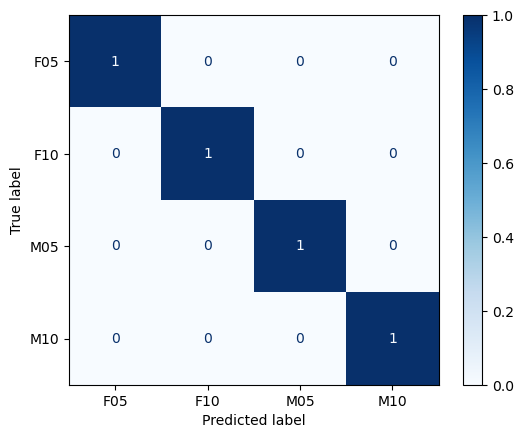

classifier one
testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 30
reverb False


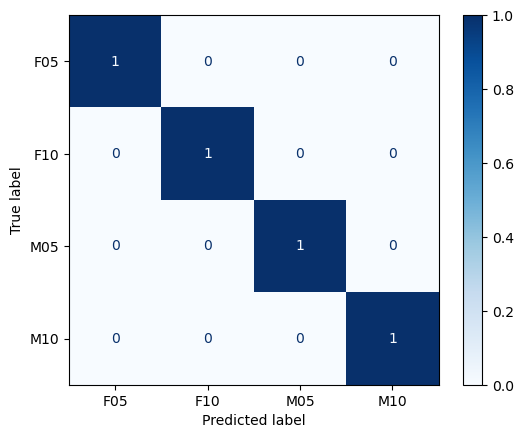

classifier one
testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 20
reverb False


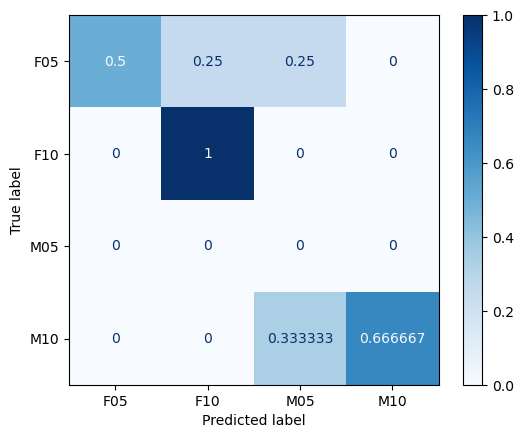

In [31]:
# processing
process_methods = [
    process_method_base.ProcessMethodBase(snr_db=40, reverb=False, model=model, get_speech_timestamps=get_speech_timestamps),
    process_method_base.ProcessMethodBase(snr_db=30, reverb=False,
    model=model, get_speech_timestamps=get_speech_timestamps),
        process_method_base.ProcessMethodBase(snr_db=20, reverb=False,
    model=model, get_speech_timestamps=get_speech_timestamps),
]

fe_methods = [
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC)
]

classifiers = {}
for i in range(len(fe_methods)):
    print('classifier one')
    classifier = classifier_gmm_ubm.ClassifierGMMUBM(fe_methods[i], process_methods[i])
    classifier.set_normalisation(adsTest)
    classifier.train(ads_train=adsTrain)
    classifier.enroll(adsEnroll)
    classifier.test_all(adsTest)